# Intel Image Classification : an `Image Classification` Problem

Source: https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
import boto3
import sagemaker
import json
import numpy as np
from PIL import Image

# Preparing image datasets

The Computer Vision algorithms in SageMaker support three input formats:

- Image files
- RecordIO files
- Augmented manifests built by SageMaker Ground Truth

For this DEMO we are going to use `Image files` format

## Data Preparation

In [2]:
!pwd

/home/ec2-user/SageMaker/FBLive_Amazon_SageMaker


In [3]:
!ls dataset/scenedataset/

pred  train  train_lst	val  val_lst


Images are described in a `lst file`, a text file containing a line per image. 
For image classification, three columns are present: 

- `unique identifier` of the image
- `class` label
- `path`

We can use a simple program that is part of Apache MXNet to create this `lst file`. 

This program is called `im2rec.py`, and it's available in Python and C++.

In [5]:
!wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py

--2021-06-29 19:30:11--  https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15838 (15K) [text/plain]
Saving to: ‘im2rec.py.2’

im2rec.py.2         100%[===================>]  15.47K  --.-KB/s    in 0s      

2021-06-29 19:30:11 (82.7 MB/s) - ‘im2rec.py.2’ saved [15838/15838]



In [6]:
!python3 im2rec.py --list --recursive dataset/scenedataset/val dataset/scenedataset/val

buildings 0
forest 1
glacier 2
mountain 3
sea 4
street 5


## Copying data to S3

In [7]:
bucket  = "aws-ml-demo-2020"
prefix  = "scenedataset"

In [8]:
!aws s3 sync dataset/scenedataset/. s3://{bucket}/{prefix}/input

upload: dataset/scenedataset/val.lst to s3://aws-ml-demo-2020/scenedataset/input/val.lst
                                                                                     


### Define the location of the Data Set

<img src="img/s3_data_structure.png"/>


In [9]:
# Testing 
s3_train_path     = 's3://{}/{}/input/train/'.format(bucket, prefix)
s3_train_lst_path = 's3://{}/{}/input/train_lst/'.format(bucket, prefix)

# Validation 
s3_val_path       = 's3://{}/{}/input/val/'.format(bucket, prefix)
s3_val_lst_path   = 's3://{}/{}/input/val_lst/'.format(bucket, prefix)

# Output 
s3_output         = 's3://{}/{}/output/'.format(bucket, prefix)

print(s3_train_path)
print(s3_val_path)
print(s3_train_lst_path)
print(s3_val_lst_path)
print(s3_output)

s3://aws-ml-demo-2020/scenedataset/input/train/
s3://aws-ml-demo-2020/scenedataset/input/val/
s3://aws-ml-demo-2020/scenedataset/input/train_lst/
s3://aws-ml-demo-2020/scenedataset/input/val_lst/
s3://aws-ml-demo-2020/scenedataset/output/


# Amazon SageMaker

- When running a training job, SageMaker reads input data from Amazon S3, uses that data to train a model. 
- Training data from S3 is made available to the Model Training instance container, which is pulled from Amazon Elastic Container Registry(`ECR`). 
- The training job saves the model artifacts back to the output S3 location designated in the training job configuration. 
- When we are ready to deploy a model, SageMaker spins up new ML instances and pulls in these model artifacts to use for batch or real-time model inference.

<img src = "img/sm-training.png" >

# Train on Amazon SageMaker

<img src = "img/sm-estimator1.png" >

### Get the name of the image classification algorithm in our region

SageMaker algorithms are packaged in Docker containers.

Using boto3 and `get_image_uri()` API, we can easily find the name of the `image-classification` algorithm in the region

In [10]:
from sagemaker import image_uris 

region_name = boto3.Session().region_name
container = image_uris.retrieve('image-classification',region_name)

print(container)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


### 1. Configure the training job

Once we know the name of the container, we can configure our training job
with the `Estimator` object. In addition to the container name, we also pass the
IAM role that SageMaker instances will use, the instance type and instance count
to use for training, as well as the output location for the model. 

Estimator will generate a training job automatically

In [11]:
role = sagemaker.get_execution_role()
session = sagemaker.Session()

ic = sagemaker.estimator.Estimator(container,
                                   role, 
                                   instance_count=1, 
                                   instance_type='ml.p3.2xlarge',
                                   output_path=s3_output,
                                   sagemaker_session=session)

### 2. Set algorithm parameters

In [12]:
ic.set_hyperparameters(num_layers=50,                 
                       use_pretrained_model=1,        
                       num_classes=6,                 
                       num_training_samples=14034,    
                       mini_batch_size=128,
                       resize=224,
                       learning_rate=0.01,
                       epochs=5)    

In [13]:
ic.set_hyperparameters(num_layers=50,                 # The number of layers in each set is based on the ResNet paper
                       use_pretrained_model=1,        # Flag to use pre-trained model for training
                       num_classes=6,                 # Plain Road or Pothole Road
                       num_training_samples=14034,    # Number of training samples
                       mini_batch_size=128,
                       resize=224,
                       learning_rate=0.01,
                       epochs=5)                      # Learn the training samples 10 times

### 3. Set dataset parameters

In [14]:
from sagemaker import TrainingInput

train_data = TrainingInput(s3_train_path, 
                           distribution='FullyReplicated', 
                           content_type='application/x-image',
                           s3_data_type='S3Prefix')

val_data  = TrainingInput(s3_val_path,
                          distribution='FullyReplicated', 
                          content_type='application/x-image', 
                          s3_data_type='S3Prefix')

train_lst_data = TrainingInput(s3_train_lst_path, 
                               distribution='FullyReplicated', 
                               content_type='application/x-image',
                               s3_data_type='S3Prefix')

val_lst_data = TrainingInput(s3_val_lst_path,
                             distribution='FullyReplicated', 
                             content_type='application/x-image', 
                             s3_data_type='S3Prefix')

s3_channels = {'train': train_data, 
               'validation': val_data, 
               'train_lst': train_lst_data, 
               'validation_lst': val_lst_data}

### 4. Train the model

In [15]:
%%time

ic.fit(inputs=s3_channels)

2021-06-29 19:30:23 Starting - Starting the training job...
2021-06-29 19:30:49 Starting - Launching requested ML instancesProfilerReport-1624995023: InProgress
.........
2021-06-29 19:32:09 Starting - Preparing the instances for training.........
2021-06-29 19:33:50 Downloading - Downloading input data...............
2021-06-29 19:36:19 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[06/29/2021 19:36:27 INFO 140235197163328] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/image_classification/default-input.json: {'use_pretrained_model': 0, 'num_layers': 152, 'epochs': 30, 'learning_rate': 0.1, 'lr_scheduler_factor': 0.1, 'optimizer': 'sgd', 'momentum': 0, 'weight_decay': 0.0001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps': 1e-08, 'gamma': 0.9, 'mini_batch_size': 32, 'image_shape': '3,224,224', 'precision_dtype': 'float32'}
[06/29/2021 19:36:27 INFO 140235197163328] Merging with provided configur

### 5. Deploy the model

In [16]:
ic_predictor = ic.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------------!

### 6. Test and Validation

In [17]:
from glob import glob

test_folders = sorted(glob('dataset/scenedataset/pred/*'))
len(test_folders)

7301

In [18]:
import cv2

def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')
    
def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0, 3, 1, 2)
    grid_img = torchvision.utils.make_grid(images, nrow = 11)
    plt.figure(figsize = (24, 12))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

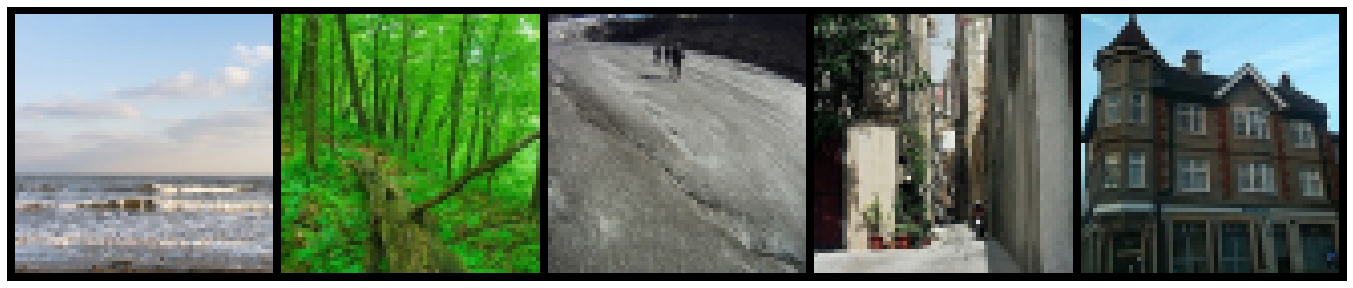

In [19]:
#Show Random Sample Image.
import torchvision
import torch
import matplotlib.pyplot as plt

sample_images = [np.random.choice(test_folders) for _ in range(5)]
show_sign_grid(sample_images)

In [20]:
sample_images

['dataset/scenedataset/pred/1544.jpg',
 'dataset/scenedataset/pred/16780.jpg',
 'dataset/scenedataset/pred/21938.jpg',
 'dataset/scenedataset/pred/22781.jpg',
 'dataset/scenedataset/pred/20132.jpg']

### Predict test image

In [26]:
# Classification map 
class_lables = {0: "buildings", 
                1: "forest",
                2: "glacier",
                3: "mountain",
                4: "sea",
                5: "street"}

# Load test image from file

for file_name in sample_images:
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)


    # Predict image and print result
    result = ic_predictor.predict(payload, initial_args={"ContentType": "application/x-image"})
    result = json.loads(result)
    class_max_pro = np.argmax(result)
    class_prediction = class_lables[class_max_pro]

    print(f"Predicted Image : {class_prediction}")
    #print(f"Probability Distribution : {result}")

Predicted Image : sea
Predicted Image : forest
Predicted Image : glacier
Predicted Image : street
Predicted Image : buildings


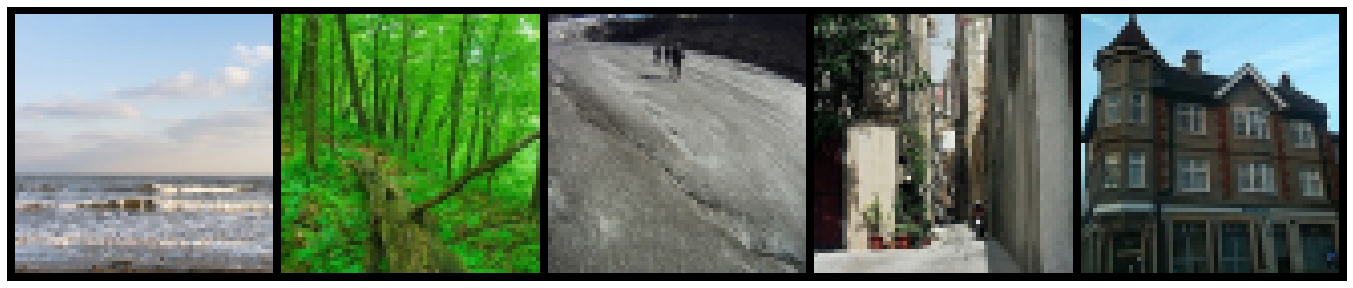

In [22]:
show_sign_grid(sample_images)

### 7. Delete endpoint

In [23]:
#ic_predictor.delete_endpoint()